# The Architecture Of The BPTK_PY Framework

This document explains the overall architecture of the BPTK framework.

## BPTK Components

The BPTK framework was designed to meet a number of objectives:

* Provide the modeler and analyst working in a Jupyter notebook environment with a easy to use API, bearing in mind that such analysts may not be expert Python developers.
* Provide the ability to run simulations standalone (i.e. outside of a notebook environment)
* The framework should be as light-weight as possible, yet easily extensible
* Focus on modeling and simulation and reuse libraries such as [Pandas](http://pandas.pydata.org>) and [Matplotlib](http://www.matplotlib.org>) for manipulating and plotting simulation results.

Currently the framework has five conceptual building blocks:

* *ABM component.* A component that allows you to build and run simulations in Python, using an Agent-based modeling approach, a System Dynamics modelling approach or both. This component contains a number of classes that you will need to build such models - please read the notebooks on [agent-based modeling](bptk_py_abm_intro.ipynb) and [System Dynamics modeling](bptk_py_sd_dsl_intro.ipynb) for this.
* *XMILE component.* A component that (automatically) translates System Dynamic models conforming to the XMILE standard into Python code. This component is a wrapper for our SDCC compiler, which is implemented in Javasvript. The component is completely transparent to the user, it does not have a public API.
* *Scenario Management Component*. A component that lets you define and manage simulation scenarios in a uniform manner.
* *Visualisation Component*. A component that visualises the results produced by simulations, in the form of plots or dashboards. This component is transparent to the user, it doesn't have a public API.
* *BPTK component*. A high level API that lets you interact with the other components using a simple and uniform API. In particular, this component allows you to run scenarios and plot scenario results from both models created in Python or translated from XMILE in a uniform manner.

The diagram below shows these building blocks and their dependencies.


## How The Components Work Together At Runtime

Now let's see what happens at runtime, assuming that we are in a Jupyter notebook.

First of all we initialize the framework by creating a ``bptk`` object. This automatically causes the framework to read all scenario config files from the ``scenario`` directory. The location of this directory can be configured in the frameworks config file.

In [5]:
## BPTK Package
from BPTK_Py.bptk import bptk 

bptk = bptk()

For each scenario manager in the config files, a scenario manager object is created, which again will contain a reference to all the scenarios defined in the config file.

Depending on whether a scenario relates to a Python model or an XMILE model, the scenario will either be a correctly configured instance of the Python model or it will contain all the equations transpiled from the XMILE model.

For each model file (XMILE models or Python classes) or config file (JSON files=, a monitoring process is set up - the monitoring process continuously observes the files in the filesystem, if the file is update the scenarios or models are reloaded. This is extremely useful, because it enables you to work on a model and the Jupyter notebook you are using to interact with the model in parallel.

At this stage, all scenario managers, scenarios and models have been instantiated and configured according to the scenario definitions, but the have not run yet.

You can take a look at all the scenarios that have been loaded using the following piece of code – this is particularly useful for debugging purposes:

In [7]:

print()
print("Available Scenario Managers and Scenarios:")
print()
managers = bptk.scenario_manager_factory.get_scenario_managers()

for key, manager in managers.items():
     print("")
     print("*** {} ***".format(key))

     for name in manager.get_scenario_names():
         print("\t {}".format(name))


Available Scenario Managers and Scenarios:


*** smSimpleProjectManagementDslClass ***
	 scenario100_strategy
	 scenario100
	 scenario80
	 scenario120

*** ABMsmSimpleProjectManagement ***
	 scenario80
	 scenario100
	 scenario120
	 scenario80DT1
	 scenario100SM2D50
	 scenario100SM2D90

*** anotherSimpleProjectManagement ***
	 scenario100
	 scenario80
	 scenario120

*** smSimpleProjectManagement ***
	 base
	 scenario100
	 scenario80
	 scenario120
	 scenario100WithPoints

*** smInteractive ***
	 scenario100

*** smSimpleProjectManagementV0 ***
	 base
	 scenario100
	 scenario80
	 scenario120

*** ABMsmBass ***
	 scenarioBassBase


Sofar, none of the scenarios have been simulated yet. You could now run scenario by calling ``bptk.run_simulation()``, which runs the simulation and returns a dataset. But in most cases you probably want to visualise the results directly, in which case ``bptk.plot_scenario`` is the method to use.

Ler's choose one of the scenarios from the list above, e.g. the ``scenario120`` from the ``smSimpleProjectManagement`` scenario manager. You can run the simulation and plot the behviour of the open tasks and closed tasks using the following command:

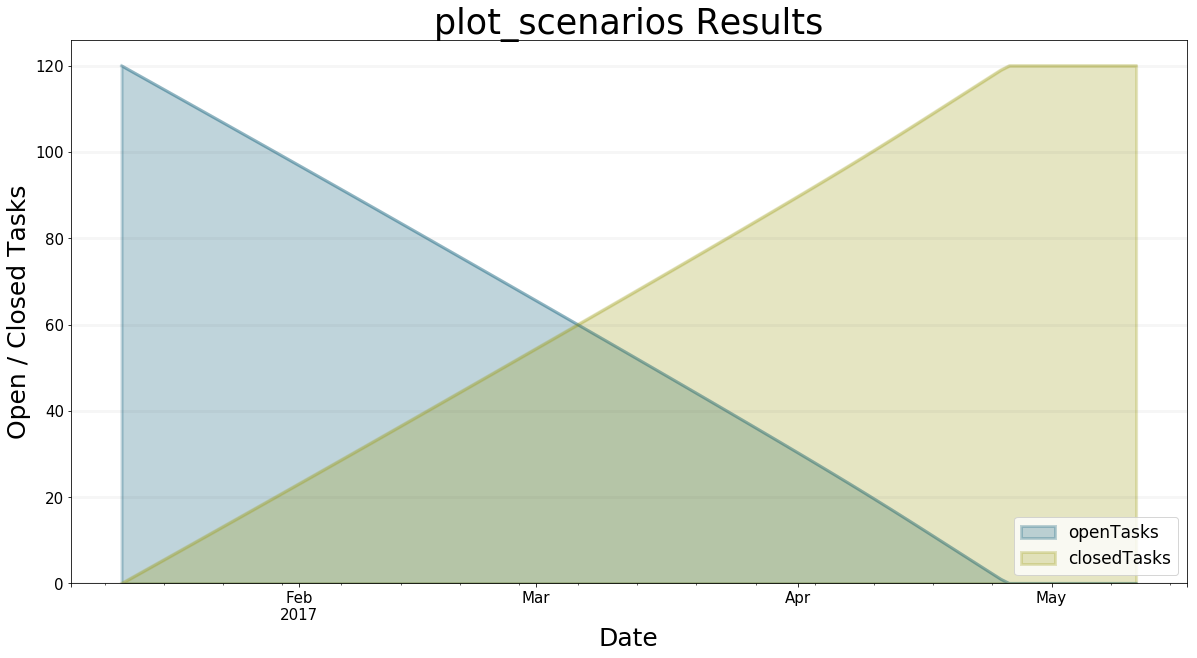

In [4]:
   bptk.plot_scenarios(
        scenario_managers=["smSimpleProjectManagement"],
        scenarios=["scenario120"],
        equations=['openTasks',"closedTasks"],
        title="plot_scenarios Results",
        x_label="Date",
        y_label="Open / Closed Tasks",
        start_date="1/11/2017",
        freq="D"
    )

What happens behind the scenes in order to produce this result?

As mentioned above, the ``bptk`` object doesn't contain much logic of its own, because we want to decouple the API from the components that actually *do* things.

The first thing the framework needs to do find the right scenario – it does this via the frameworks ``ScenarioManagerFactory`` – this object is created as soon as the ``bptk`` object is created and it contains a list of known scenario managers (which are mostly created indirectly via the config files, but can also be created at runtime).

Assuming that the framework can locate the right scenario manager, it then instantiates a model for the scenario we passed. In our case this is a model that was created using Stella Architect and is stored in XMILE-Format (in simulation_models/sd_simple_project.itmx). This model was automatically transpiled into a python class ``simulation_models/sd_simple_project.py`` as soon as the framework was initialized and the scenarios where read. You can actually test this by simply deleting this Python file - the framework automatically detects this and re-transpiles the model.

So the framework locates the Python class that was created by the XMILE transpiler, instantiates the model with the scenario settings defined by the scenario, and runs both the ``openTasks`` and ``closedTasks`` equations. The framework knows which class to look for because both the name of the XMILE-model and the name of the transpiled class are defined in the scenario configuration file in the source and model parameters:

```json

    "source":"simulation_models/sd_simple_project.itmx",
    "model":"simulation_models/sd_simple_project"
```

These dataframes are then passed to the visualisation component to be visualised as plots. This component is actually completely transparent to the user, it doesn't have any public classes.

## Classes For Agent-based Modeling

The basic concept behind AB models is quite simple: you populate an environment (the model) with a set of agents. Agents and the environment each have a set of properties and each agent must always be in a defined state. Agents can perform actions and interact amongst each other and with the environment by sending each other events - the agents react to these events by updating their properties and/or changing their state.

You can get a brief introduction to ABM with BPTK_PY [here](bptk_py_abm_intro.ipynb).

Behind the scenes, ABM framework consists of five classes that work together to create the simulation:

* __Model__. The model maintains a list of all agents in the simulatio and defines the properties of the environment. The model also caches all events sent by agents Models are configured using scenarios - a new model is instantiated for each scenario.
* __Agent__. All agents must be derived from the Agent base class. Agents implement handlers to deal with events, an initialize method to set initial properties and an act method which implements agents behaviour. The events are dispatched to the agent by the scheduler, the event handlers are called automatically, just before the act method is executed.
* __Scheduler__. A scheduler is responible for actually running the simulation - it first dispatches the events cached in the model to the agents. Then it ensures that the agents event handlers are called before calling the agents act methods. The default scheduler is the SimultaneousScheduler - this ensures that all events are dispatched to all agents before their act methods are called. The number and granularity of time steps in the simulation is specified in the scenario config file.
* __Event__. Events are used to transport data between agents. The data is stored in dictionaries, events are identified by their name. Each event also contains the IDs of the sending and receiving agents.
* __DataCollector__. A data collector is responsible for collecting statistics on agents, their states and their properties.  These statistics are the basis for creating plots using the plot_scenario method. The default DataCollector collects statistics on all agent states and properties. Depending on the size  of the model and the number of time steps, this can take a long time. Hence it is possible to implement DataCollectors that only collect data for specific attributes and agents, in order to increase simulation efficiency.